In [1]:
import pandas as pd
import numpy as np
from gerrychain.random import random

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

/home/imm/hert6114/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!export PYTHONHASHSEED=0

In [3]:
def get_data(filename, to_numpy=True):
    df = pd.read_parquet(
        f'../data/models/python/lightgbm/{filename}.parquet', 
        use_threads=True
    )
            
    target_col = 'predictor'
    features = [col for col in df.columns if col != target_col]
    
    y = df[target_col].map({'YES': 1, 'NO': 0})
    X = df[features]
    
    if to_numpy:
        y = y.to_numpy(dtype=np.float32)
        X = X.to_numpy(dtype=np.float32)
    
    return X, y, features

In [4]:
bw = 1
cpu = 4
seed = 1234
n_trials = 100
n_train_iter = n_trials * 4

In [5]:
np.random.seed(seed)
random.seed(seed)

In [6]:
def objective(trial):
    try:
        X, y, _ = get_data(filename='train', to_numpy = True)
        
        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "device": "gpu",
            "num_threads": cpu,
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "subsample": trial.suggest_float("subsample", 0.1, 1.0)
        }
    
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        aurocs = []
        
        for train_idx, valid_idx in kf.split(X, y):
            X_train, X_valid = X[train_idx], X[valid_idx]
            y_train, y_valid = y[train_idx], y[valid_idx]
                        
            model = lgb.LGBMClassifier()
            model.set_params(**params)
            model.fit(X_train, y_train)
            y_probs = model.predict_proba(X_valid)[:, 1]
            
            fpr, tpr, _ = roc_curve(y_valid, y_probs)
            auroc = auc(fpr, tpr)
            aurocs.append(auroc)
        
        return np.mean(aurocs)
    
    except lgb.basic.LightGBMError as e:
        return -np.inf

In [7]:
sampler = TPESampler(seed=seed)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=n_train_iter, 
        reduction_factor=3
    )
)
study.optimize(objective, n_trials=n_trials)

[I 2024-01-28 00:11:31,227] A new study created in memory with name: no-name-2e2dbcc3-90f6-4d25-b46a-81a313775033
[I 2024-01-28 01:00:23,546] Trial 0 finished with value: 0.8217245780770127 and parameters: {'reg_alpha': 5.292672888299455e-07, 'reg_lambda': 0.003971722885615567, 'num_leaves': 45, 'learning_rate': 0.07875049978766316, 'n_estimators': 8020, 'colsample_bytree': 0.3453333447543775, 'subsample': 0.34881782962878705}. Best is trial 0 with value: 0.8217245780770127.
[I 2024-01-28 01:23:46,291] Trial 1 finished with value: 0.810988214532133 and parameters: {'reg_alpha': 0.16475917089206663, 'reg_lambda': 4.20004731740671, 'num_leaves': 88, 'learning_rate': 0.036423909725828804, 'n_estimators': 5509, 'colsample_bytree': 0.7151166416549226, 'subsample': 0.7414318242846102}. Best is trial 0 with value: 0.8217245780770127.
[I 2024-01-28 02:04:47,577] Trial 2 finished with value: 0.7364992850537702 and parameters: {'reg_alpha': 2.1491008360435867e-05, 'reg_lambda': 0.001123998352303

In [8]:
df_studytrials = study.trials_dataframe()
df_studytrials.rename(columns={'value': 'AUROC'}, inplace=True)
df_studytrials.to_csv('../data/models/python/lightgbm/best_LGBM_model_studytrials.csv', index=False)

df_studytrials.head()

,number,AUROC,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.821725,2024-01-28 00:11:31.230251,2024-01-28 01:00:23.546464,0 days 00:48:52.316213,0.345333,0.078750,8020,45,5.292673e-07,3.971723e-03,0.348818,COMPLETE
1,1,0.810988,2024-01-28 01:00:23.547870,2024-01-28 01:23:46.291547,0 days 00:23:22.743677,0.715117,0.036424,5509,88,1.647592e-01,4.200047e+00,0.741432,COMPLETE
2,2,0.736499,2024-01-28 01:23:46.293197,2024-01-28 02:04:47.576932,0 days 00:41:01.283735,0.894377,0.002363,7956,51,2.149101e-05,1.123998e-03,0.428397,COMPLETE
3,3,0.815520,2024-01-28 02:04:47.578428,2024-01-28 02:38:23.110917,0 days 00:33:35.532489,0.457482,0.093381,6863,38,3.455935e-03,4.769042e-08,0.809857,COMPLETE
4,4,0.828199,2024-01-28 02:38:23.112313,2024-01-28 03:16:38.762517,0 days 00:38:15.650204,0.229390,0.044181,8220,88,7.104362e-06,1.296844e-03,0.733835,COMPLETE


In [9]:
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  AUROC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 100
Best trial:
  AUROC: 0.8601230317154164
  Params: 
    reg_alpha: 0.22874115109030496
    reg_lambda: 0.7854561284182642
    num_leaves: 93
    learning_rate: 0.09270708463606236
    n_estimators: 9941
    colsample_bytree: 0.33406442678952747
    subsample: 0.1781788940580592


In [10]:
# importance of each hyper-parameter
optuna.visualization.plot_param_importances(study)

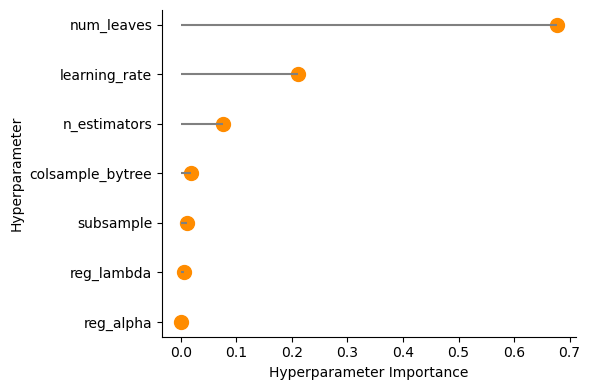

In [11]:
# importance of each hyper-parameter
hyp_imp = optuna.importance.get_param_importances(study)
hyp_imp = pd.DataFrame(hyp_imp.items(), columns=['feature', 'importance'])
hyp_imp.sort_values('importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(6,4))
y_pos = range(len(hyp_imp))
ax.hlines(y=y_pos, xmin=0, xmax=hyp_imp['importance'], color='grey')
ax.scatter(hyp_imp['importance'], y_pos, color='darkorange', s=100)
ax.set_yticks(y_pos)
ax.set_yticklabels(hyp_imp['feature'])

# Highest importance at the top
ax.invert_yaxis()

ax.set_xlabel('Hyperparameter Importance')
ax.set_ylabel('Hyperparameter')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig(f'../figures/python/lightgbm/LightGBM_Hyperparameter_Importance.pdf', dpi=600, bbox_inches='tight')
plt.show()

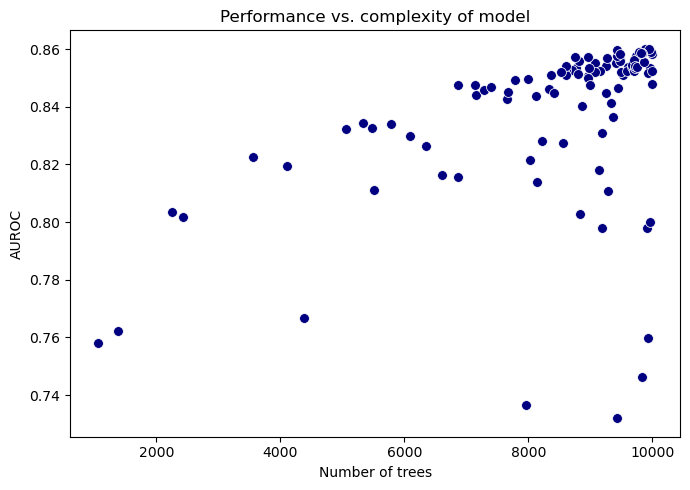

In [12]:
all_auroc_values = [trial.values[0] for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
all_trees = [trial.params['n_estimators'] for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
model_complexity = pd.DataFrame({'Number of trees': all_trees, 'AUROC': all_auroc_values})

# visualise aucroc vs. complexity
plt.figure(figsize=(7,5))
sns.scatterplot(data=model_complexity, x='Number of trees', y='AUROC', color='navy', s=50)

plt.title('Performance vs. complexity of model')
plt.tight_layout()

plt.savefig(f'../figures/python/lightgbm/LightGBM_Classifier_AUROC-vs-Trees.png', dpi=600, bbox_inches='tight')

plt.show()

In [13]:
model_complexity['AUROC'] = model_complexity['AUROC'].apply(lambda x: '{:.3f}'.format(x))
model_complexity.sort_values(by=['AUROC', 'Number of trees'], ascending=False, inplace=True)
model_complexity.groupby('AUROC')['Number of trees'].min().tail(20)

AUROC
0.840    8862
0.841    9340
0.843    7658
0.844    7151
0.845    7675
0.846    7285
0.847    7404
0.848    6868
0.849    7780
0.850    8001
0.851    8368
0.852    8522
0.853    8614
0.854    8614
0.855    9075
0.856    8822
0.857    8745
0.858    9472
0.859    9788
0.860    9423
Name: Number of trees, dtype: int64

In [14]:
target_trees = 6863
max_auroc = -1
desired_trial = None

# # Iterate through the completed trials
# for trial in study.trials:
#     if trial.state == optuna.trial.TrialState.COMPLETE and trial.params['n_estimators'] == target_trees:
#         if trial.value > max_auroc:
#             max_auroc = trial.value
#             desired_trial = trial

In [15]:
if desired_trial:
    print(f"Trial with {target_trees} trees found.")
    print(f"  AUROC: {desired_trial.value}")
    print("  Params: ")
    for key, value in desired_trial.params.items():
        print(f"    {key}: {value}")

    # Apply the model with the specific number of trees to X_test, y_test
    best_params = desired_trial.params
else:
    print(f"Number of finished trials: {len(study.trials)}")
    print("Best trial:")
    trial = study.best_trial
    print(f"  AUROC: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    best_params = trial.params

Number of finished trials: 100
Best trial:
  AUROC: 0.8601230317154164
  Params: 
    reg_alpha: 0.22874115109030496
    reg_lambda: 0.7854561284182642
    num_leaves: 93
    learning_rate: 0.09270708463606236
    n_estimators: 9941
    colsample_bytree: 0.33406442678952747
    subsample: 0.1781788940580592


In [16]:
best_params["objective"]="binary"
best_params["metric"]="binary_logloss"
best_params["verbosity"]=1
best_params["boosting_type"]="gbdt"
best_params["device"]="gpu"
best_params["num_threads"]=cpu

X_train, y_train, _ = get_data(filename='train', to_numpy = True)
X_test, y_test, feature_names = get_data(filename='test', to_numpy = False)

best_model = lgb.LGBMClassifier()
best_model.set_params(**best_params)

LGBMClassifier(colsample_bytree=0.33406442678952747, device='gpu',
               learning_rate=0.09270708463606236, metric='binary_logloss',
               n_estimators=9941, num_leaves=93, num_threads=4,
               objective='binary', reg_alpha=0.22874115109030496,
               reg_lambda=0.7854561284182642, subsample=0.1781788940580592,
               verbosity=1)

In [17]:
best_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 821866, number of negative: 1055064
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53008
[LightGBM] [Info] Number of data points in the train set: 1876930, number of used features: 640
[LightGBM] [Info] Using GPU Device: NVIDIA RTX A6000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 579 dense feature groups (1038.19 MB) transferred to GPU in 0.392741 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437878 -> initscore=-0.249779
[LightGBM] [Info] Start training from score -0.249779


LGBMClassifier(colsample_bytree=0.33406442678952747, device='gpu',
               learning_rate=0.09270708463606236, metric='binary_logloss',
               n_estimators=9941, num_leaves=93, num_threads=4,
               objective='binary', reg_alpha=0.22874115109030496,
               reg_lambda=0.7854561284182642, subsample=0.1781788940580592,
               verbosity=1)

In [18]:
best_model.booster_.save_model('../data/models/python/lightgbm/best_LGBM_model.txt')

In [19]:
# Make predictions on the test set
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auroc = auc(fpr, tpr)

print("AUC on test set:", auroc)

AUC on test set: 0.8903990882228703


In [20]:
num_features=25

In [17]:
# match hex codes
group_colors = {
    'QM_PARAMETERS': 'salmon',
    'G4MAP': 'blue',
    'BREAKS': 'purple',
    'LONGRANGE_PREPARAMS': 'purple',
    'G4_REGEX': 'darkorange',
    'SINGLETON': 'brown',
    'GC_CONTENT': 'pink',
    'GC_COUNT': 'gray',
    'KMER_COUNTS': 'olive',
    'VIENNA_RNA': 'cornflowerblue',
    'DNA_SHAPE': 'deeppink'
}

df_colnames = pd.read_csv("../data/ML_demo/K562_Top2_mediated_DSBs_kmerwindow-5crash_test-TRUEonly_breaks-TRUEkmer-8_seed-41964_zscore_colnames.csv")
df_colnames['hex'] = df_colnames['group'].map(group_colors)

X_test, y_test, feature_names = get_data(filename='test', to_numpy = False)

feature_importances = best_model.feature_importances_
feature_importances = feature_importances / feature_importances.max()
feature_importances = pd.DataFrame({
    'feature': feature_names, 
    'importance': feature_importances
})
feature_importances.sort_values('importance', ascending=False, inplace=True)

# find contribution of breakage scores in full table of features
cols_group_dict = pd.Series(df_colnames['group'].values, index=df_colnames['columns']).to_dict()
feature_importances['group'] = feature_importances['feature'].map(cols_group_dict)

# match hex codes
cols_hex_dict = pd.Series(
    df_colnames['hex'].values, 
    index=df_colnames['columns']
).to_dict()
feature_importances['hex'] = feature_importances['feature'].map(cols_hex_dict)

all_coefs = feature_importances['importance'].sum()
group_contr = feature_importances.groupby('group')['importance'].sum() / all_coefs * 100

feature_importances.fillna('#787878', inplace=True)

In [49]:
feature_importances.reset_index().head(50)

,index,feature,importance,group,hex
0,65,AsiSI_restriction_enzyme_AID-Diva_cells_LR_sum,1.000000,LONGRANGE_PREPARAMS,purple
1,119,RPE1_cells_Top2_Loss_VP16_LR_sum,0.765751,LONGRANGE_PREPARAMS,purple
2,124,Twist_library_C25cl48_cells_LR_sum,0.762652,LONGRANGE_PREPARAMS,purple
3,115,Nt_BbvCI_restriction_enzyme_K562_cells_NT_LR_sum,0.752530,LONGRANGE_PREPARAMS,purple
4,90,HCT116_cells_siWRN_WRN_Loss_LR_sum,0.732906,LONGRANGE_PREPARAMS,purple
5,118,RPE1_cells_Top2_Loss_NT_LR_sum,0.731874,LONGRANGE_PREPARAMS,purple
6,116,Nt_BbvCI_restriction_enzyme_K562_cells_Sap_LR_sum,0.684156,LONGRANGE_PREPARAMS,purple
7,105,KM12_cells_siWRN_WRN_Loss_LR_sum,0.658542,LONGRANGE_PREPARAMS,purple
8,117,Recombination_rates_LR_sum,0.654617,LONGRANGE_PREPARAMS,purple
9,103,KM12_cells_APH-ATRI_WRN_Loss_LR_sum,0.645734,LONGRANGE_PREPARAMS,purple


In [ ]:
feature_importances.to_csv(
    '../data/models/python/lightgbm/best_LGBM_model_feature_importance.csv', 
    index=False
)
pd.DataFrame({'TPR': tpr, 'FPR': fpr}).to_csv(
    '../data/models/python/lightgbm/best_LGBM_model_ROC_curve.csv', 
    index=False
)

In [40]:
feature_importances = feature_importances.head(num_features)

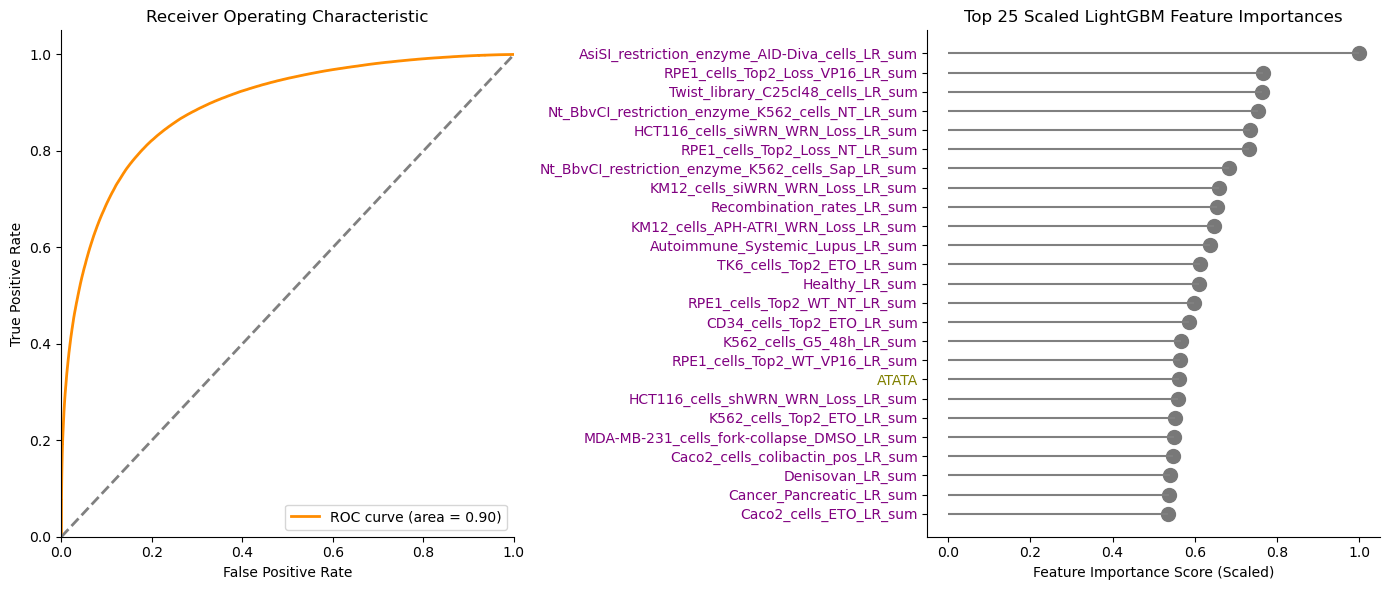

In [41]:
# Set up the matplotlib figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot AUROC Curve
ax1 = axs[0]
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.90)')
ax1.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# Plot Feature Importance (Horizontal Lollipop plot)
ax2 = axs[1]
y_positions = range(len(feature_importances))
ax2.hlines(y=y_positions, xmin=0, xmax=feature_importances['importance'], color='grey')
ax2.scatter(feature_importances['importance'], y_positions, color='#787878', s=100)
ax2.set_yticks(y_positions)
ax2.set_yticklabels(feature_importances['feature'])

# Highest importance at the top
ax2.invert_yaxis()
ax2.set_title(f'Top {num_features} Scaled LightGBM Feature Importances')
ax2.set_xlabel('Feature Importance Score (Scaled)')

# Coloring y-axis labels based on hex color in the table
for index, label in enumerate(plt.gca().get_yticklabels()):
    hex_color = feature_importances.iloc[index]['hex']
    label.set_color(hex_color)

for i in range(len(axs)):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig(f'../figures/python/lightgbm/LightGBM_Classifier.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [43]:
def find_threshold_for_fpr(fpr, tpr, thresholds, target_fpr=0.2):
    idx = np.argmin(np.abs(fpr - target_fpr))
    return thresholds[idx], fpr[idx], tpr[idx]

In [44]:
thresholds_df = pd.DataFrame(columns=["threshold", "FPR", "TPR"])
target_fprs = [0.001, 0.005, 0.01, 0.05]

for t_fpr in target_fprs:
    threshold, actual_fpr, TPR = find_threshold_for_fpr(fpr, tpr, thresholds, t_fpr)
    thresholds_df = thresholds_df.append({
        "threshold": threshold, 
        "FPR": t_fpr, 
        "TPR": TPR,
        'TPR_FPR_ratio': TPR / t_fpr
    }, ignore_index=True)
    
thresholds_df

,threshold,FPR,TPR,TPR_FPR_ratio
0,0.944715,0.001,0.134947,134.947065
1,0.876269,0.005,0.245827,49.165453
2,0.82554,0.01,0.315864,31.586449
3,0.621225,0.05,0.555804,11.116070


In [45]:
thresholds_df.to_csv(
    '../data/models/python/lightgbm/best_LGBM_model_thresholds.csv', 
    index=False
)